# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Focal loss (gamma=0.5)

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [3]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        """
        y_pred: raw scores (logits) for each class. [batch_size, num_classes]
        y_true: ground truth labels. [batch_size]
        """
        # Convert y_true labels into one-hot encoding
        y_true_onehot = torch.zeros(y_pred.size(), device=y_pred.device).scatter_(1, y_true.unsqueeze(1).long(), 1)
        
        # Calculate softmax over y_pred for calculating probabilities
        probs = F.softmax(y_pred, dim=1)
        
        # Calculate focal loss
        focal_loss = -self.alpha * (y_true_onehot * torch.log(probs) * (1 - probs) ** self.gamma).sum(dim=1).mean()
        
        return focal_loss

criterion = FocalLoss(gamma=0.5)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss


training_loss4 = []
training_acc4 = []
testing_loss4 = []
testing_acc4 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss4.append(epoch_loss)
        training_acc4.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss4.append(val_loss)
            testing_acc4.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))



Epoch: 1/30 Train Loss: 0.0139 Acc: 0.2817
Begin test......
Test Loss: 0.0127 Acc: 0.3521
Epoch: 2/30 Train Loss: 0.0129 Acc: 0.3319
Begin test......
Test Loss: 0.0118 Acc: 0.3758
Epoch: 3/30 Train Loss: 0.0126 Acc: 0.3451
Begin test......
Test Loss: 0.0118 Acc: 0.3962
Epoch: 4/30 Train Loss: 0.0124 Acc: 0.3564
Begin test......
Test Loss: 0.0117 Acc: 0.4013
Epoch: 5/30 Train Loss: 0.0125 Acc: 0.3582
Begin test......
Test Loss: 0.0125 Acc: 0.3718
Epoch: 6/30 Train Loss: 0.0115 Acc: 0.4013
Begin test......
Test Loss: 0.0109 Acc: 0.4210
Epoch: 7/30 Train Loss: 0.0113 Acc: 0.4148
Begin test......
Test Loss: 0.0103 Acc: 0.4710
Epoch: 8/30 Train Loss: 0.0112 Acc: 0.4182
Begin test......
Test Loss: 0.0108 Acc: 0.4467
Epoch: 9/30 Train Loss: 0.0111 Acc: 0.4258
Begin test......
Test Loss: 0.0108 Acc: 0.4338
Epoch: 10/30 Train Loss: 0.0111 Acc: 0.4281
Begin test......
Test Loss: 0.0105 Acc: 0.4525
Epoch: 11/30 Train Loss: 0.0104 Acc: 0.4570
Begin test......
Test Loss: 0.0099 Acc: 0.4754
Epoch: 1

### Focal loss (gamma=2)

In [ ]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [30]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [31]:


focal_loss2 = FocalLoss(gamma=2)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)
    ###############################################################

    return output, loss


training_loss3 = []
training_acc3 = []
testing_loss3 = []
testing_acc3 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss3.append(epoch_loss)
        training_acc3.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss3.append(val_loss)
            testing_acc3.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))




Epoch: 1/30 Train Loss: 0.0114 Acc: 0.2722
Begin test......
Test Loss: 0.0110 Acc: 0.3234
Epoch: 2/30 Train Loss: 0.0109 Acc: 0.2935
Begin test......
Test Loss: 0.0097 Acc: 0.3419
Epoch: 3/30 Train Loss: 0.0100 Acc: 0.3338
Begin test......
Test Loss: 0.0093 Acc: 0.3644
Epoch: 4/30 Train Loss: 0.0098 Acc: 0.3452
Begin test......
Test Loss: 0.0088 Acc: 0.3908
Epoch: 5/30 Train Loss: 0.0096 Acc: 0.3590
Begin test......
Test Loss: 0.0093 Acc: 0.3745
Epoch: 6/30 Train Loss: 0.0089 Acc: 0.3899
Begin test......
Test Loss: 0.0083 Acc: 0.4248
Epoch: 7/30 Train Loss: 0.0086 Acc: 0.4047
Begin test......
Test Loss: 0.0082 Acc: 0.4303
Epoch: 8/30 Train Loss: 0.0086 Acc: 0.4080
Begin test......
Test Loss: 0.0082 Acc: 0.4330
Epoch: 9/30 Train Loss: 0.0086 Acc: 0.4095
Begin test......
Test Loss: 0.0082 Acc: 0.4283
Epoch: 10/30 Train Loss: 0.0085 Acc: 0.4146
Begin test......
Test Loss: 0.0083 Acc: 0.4264
Epoch: 11/30 Train Loss: 0.0080 Acc: 0.4396
Begin test......
Test Loss: 0.0080 Acc: 0.4447
Epoch: 1

### CrossEntropyLoss

In [6]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
ce_loss = nn.CrossEntropyLoss()
def train_batch(model, image, target):
    model.train()
    output = model(image)
    loss = ce_loss(output, target)
    return output, loss

def test_batch(model, image, target):
    model.eval()
    with torch.no_grad():
        # Use the provided model for inference
        output = model(image)
        loss = ce_loss(output, target)
    return output, loss

training_loss1 = []
training_acc1 = []
testing_loss1 = []
testing_acc1 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss1.append(epoch_loss)
    training_acc1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss1.append(val_loss)
        testing_acc1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0148 Acc: 0.2918
Begin test......
Test Loss: 0.0133 Acc: 0.3830
Epoch: 2/30 Train Loss: 0.0138 Acc: 0.3503
Begin test......
Test Loss: 0.0131 Acc: 0.3861
Epoch: 3/30 Train Loss: 0.0135 Acc: 0.3600
Begin test......
Test Loss: 0.0132 Acc: 0.3810
Epoch: 4/30 Train Loss: 0.0135 Acc: 0.3597
Begin test......
Test Loss: 0.0131 Acc: 0.3903
Epoch: 5/30 Train Loss: 0.0135 Acc: 0.3669
Begin test......
Test Loss: 0.0125 Acc: 0.4238
Epoch: 6/30 Train Loss: 0.0126 Acc: 0.4083
Begin test......
Test Loss: 0.0117 Acc: 0.4579
Epoch: 7/30 Train Loss: 0.0124 Acc: 0.4198
Begin test......
Test Loss: 0.0118 Acc: 0.4480
Epoch: 8/30 Train Loss: 0.0124 Acc: 0.4216
Begin test......
Test Loss: 0.0122 Acc: 0.4410
Epoch: 9/30 Train Loss: 0.0123 Acc: 0.4225
Begin test......
Test Loss: 0.0116 Acc: 0.4699
Epoch: 10/30 Train Loss: 0.0122 Acc: 0.4354
Begin test......
Test Loss: 0.0116 Acc: 0.4685
Epoch: 11/30 Train Loss: 0.0117 Acc: 0.4605
Begin test......
Test Loss: 0.0109 Acc: 0.5007
Epoch: 1

### MAE(L1)Loss function:

In [8]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
mae_loss = nn.L1Loss()

def train_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1))
    loss = mae_loss(output, target)
    return output, loss

def test_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1)) 
    loss = mae_loss(output, target)
    return output, loss

training_loss2 = []
training_acc2 = []
testing_loss2 = []
testing_acc2 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_mae(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss2.append(epoch_loss)
    training_acc2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch_mae(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss2.append(val_loss)
        testing_acc2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0204 Acc: 0.0978
Begin test......
Test Loss: 0.0191 Acc: 0.0887
Epoch: 2/30 Train Loss: 0.0190 Acc: 0.0907
Begin test......
Test Loss: 0.0185 Acc: 0.1129
Epoch: 3/30 Train Loss: 0.0188 Acc: 0.0970
Begin test......
Test Loss: 0.0187 Acc: 0.0963
Epoch: 4/30 Train Loss: 0.0186 Acc: 0.0975
Begin test......
Test Loss: 0.0183 Acc: 0.0851
Epoch: 5/30 Train Loss: 0.0184 Acc: 0.0977
Begin test......
Test Loss: 0.0180 Acc: 0.1079
Epoch: 6/30 Train Loss: 0.0182 Acc: 0.0970
Begin test......
Test Loss: 0.0178 Acc: 0.0855
Epoch: 7/30 Train Loss: 0.0180 Acc: 0.0989
Begin test......
Test Loss: 0.0177 Acc: 0.1025
Epoch: 8/30 Train Loss: 0.0179 Acc: 0.0982
Begin test......
Test Loss: 0.0173 Acc: 0.0714
Epoch: 9/30 Train Loss: 0.0177 Acc: 0.0977
Begin test......
Test Loss: 0.0173 Acc: 0.0702
Epoch: 10/30 Train Loss: 0.0175 Acc: 0.0962
Begin test......
Test Loss: 0.0171 Acc: 0.0961
Epoch: 11/30 Train Loss: 0.0173 Acc: 0.0955
Begin test......
Test Loss: 0.0169 Acc: 0.0934
Epoch: 1

### learning_rate=1e-2

### focal loss(gamma=0.5)

In [10]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [11]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        """
        y_pred: raw scores (logits) for each class. [batch_size, num_classes]
        y_true: ground truth labels. [batch_size]
        """
        # Convert y_true labels into one-hot encoding
        y_true_onehot = torch.zeros(y_pred.size(), device=y_pred.device).scatter_(1, y_true.unsqueeze(1).long(), 1)
        
        # Calculate softmax over y_pred for calculating probabilities
        probs = F.softmax(y_pred, dim=1)
        
        # Calculate focal loss
        focal_loss = -self.alpha * (y_true_onehot * torch.log(probs) * (1 - probs) ** self.gamma).sum(dim=1).mean()
        
        return focal_loss

criterion = FocalLoss(gamma=0.5)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss


training_loss4_2 = []
training_acc4_2 = []
testing_loss4_2 = []
testing_acc4_2 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss4_2.append(epoch_loss)
        training_acc4_2.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss4_2.append(val_loss)
            testing_acc4_2.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))




Epoch: 1/30 Train Loss: 0.0141 Acc: 0.2809
Begin test......
Test Loss: 0.0114 Acc: 0.4140
Epoch: 2/30 Train Loss: 0.0116 Acc: 0.4007
Begin test......
Test Loss: 0.0104 Acc: 0.4632
Epoch: 3/30 Train Loss: 0.0110 Acc: 0.4333
Begin test......
Test Loss: 0.0100 Acc: 0.4849
Epoch: 4/30 Train Loss: 0.0105 Acc: 0.4588
Begin test......
Test Loss: 0.0095 Acc: 0.5123
Epoch: 5/30 Train Loss: 0.0102 Acc: 0.4708
Begin test......
Test Loss: 0.0100 Acc: 0.4916
Epoch: 6/30 Train Loss: 0.0098 Acc: 0.4976
Begin test......
Test Loss: 0.0091 Acc: 0.5339
Epoch: 7/30 Train Loss: 0.0096 Acc: 0.5026
Begin test......
Test Loss: 0.0088 Acc: 0.5483
Epoch: 8/30 Train Loss: 0.0095 Acc: 0.5055
Begin test......
Test Loss: 0.0089 Acc: 0.5423
Epoch: 9/30 Train Loss: 0.0095 Acc: 0.5106
Begin test......
Test Loss: 0.0088 Acc: 0.5478
Epoch: 10/30 Train Loss: 0.0094 Acc: 0.5134
Begin test......
Test Loss: 0.0089 Acc: 0.5390
Epoch: 11/30 Train Loss: 0.0092 Acc: 0.5254
Begin test......
Test Loss: 0.0086 Acc: 0.5629
Epoch: 1

### focal loss(gamma=2)

In [27]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [28]:


focal_loss2 = FocalLoss(gamma=2)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)
    ###############################################################

    return output, loss


training_loss3_2 = []
training_acc3_2 = []
testing_loss3_2 = []
testing_acc3_2 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss3_2.append(epoch_loss)
        training_acc3_2.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss3_2.append(val_loss)
            testing_acc3_2.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))





Epoch: 1/30 Train Loss: 0.0111 Acc: 0.2940
Begin test......
Test Loss: 0.0084 Acc: 0.4291
Epoch: 2/30 Train Loss: 0.0087 Acc: 0.4093
Begin test......
Test Loss: 0.0075 Acc: 0.4738
Epoch: 3/30 Train Loss: 0.0081 Acc: 0.4403
Begin test......
Test Loss: 0.0073 Acc: 0.4891
Epoch: 4/30 Train Loss: 0.0078 Acc: 0.4535
Begin test......
Test Loss: 0.0071 Acc: 0.4972
Epoch: 5/30 Train Loss: 0.0076 Acc: 0.4713
Begin test......
Test Loss: 0.0066 Acc: 0.5350
Epoch: 6/30 Train Loss: 0.0072 Acc: 0.4901
Begin test......
Test Loss: 0.0066 Acc: 0.5413
Epoch: 7/30 Train Loss: 0.0072 Acc: 0.4942
Begin test......
Test Loss: 0.0065 Acc: 0.5336
Epoch: 8/30 Train Loss: 0.0070 Acc: 0.5018
Begin test......
Test Loss: 0.0063 Acc: 0.5538
Epoch: 9/30 Train Loss: 0.0070 Acc: 0.5034
Begin test......
Test Loss: 0.0063 Acc: 0.5498
Epoch: 10/30 Train Loss: 0.0070 Acc: 0.5091
Begin test......
Test Loss: 0.0063 Acc: 0.5464
Epoch: 11/30 Train Loss: 0.0068 Acc: 0.5178
Begin test......
Test Loss: 0.0062 Acc: 0.5617
Epoch: 1

### CE loss

In [14]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
ce_loss = nn.CrossEntropyLoss()
def train_batch(model, image, target):
    model.train()
    output = model(image)
    loss = ce_loss(output, target)
    return output, loss

def test_batch(model, image, target):
    model.eval()
    with torch.no_grad():
        # Use the provided model for inference
        output = model(image)
        loss = ce_loss(output, target)
    return output, loss

training_loss1_2 = []
training_acc1_2 = []
testing_loss1_2 = []
testing_acc1_2 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss1_2.append(epoch_loss)
    training_acc1_2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss1_2.append(val_loss)
        testing_acc1_2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0153 Acc: 0.2840
Begin test......
Test Loss: 0.0129 Acc: 0.4007
Epoch: 2/30 Train Loss: 0.0129 Acc: 0.3952
Begin test......
Test Loss: 0.0117 Acc: 0.4633
Epoch: 3/30 Train Loss: 0.0121 Acc: 0.4345
Begin test......
Test Loss: 0.0113 Acc: 0.4821
Epoch: 4/30 Train Loss: 0.0118 Acc: 0.4516
Begin test......
Test Loss: 0.0108 Acc: 0.5023
Epoch: 5/30 Train Loss: 0.0116 Acc: 0.4641
Begin test......
Test Loss: 0.0105 Acc: 0.5233
Epoch: 6/30 Train Loss: 0.0110 Acc: 0.4907
Begin test......
Test Loss: 0.0103 Acc: 0.5311
Epoch: 7/30 Train Loss: 0.0109 Acc: 0.5038
Begin test......
Test Loss: 0.0101 Acc: 0.5443
Epoch: 8/30 Train Loss: 0.0107 Acc: 0.5107
Begin test......
Test Loss: 0.0099 Acc: 0.5515
Epoch: 9/30 Train Loss: 0.0107 Acc: 0.5091
Begin test......
Test Loss: 0.0098 Acc: 0.5601
Epoch: 10/30 Train Loss: 0.0106 Acc: 0.5173
Begin test......
Test Loss: 0.0097 Acc: 0.5620
Epoch: 11/30 Train Loss: 0.0103 Acc: 0.5265
Begin test......
Test Loss: 0.0095 Acc: 0.5687
Epoch: 1

### MAE loss

In [16]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
mae_loss = nn.L1Loss()

def train_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1))
    loss = mae_loss(output, target)
    return output, loss

def test_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1)) 
    loss = mae_loss(output, target)
    return output, loss

training_loss2_2 = []
training_acc2_2 = []
testing_loss2_2 = []
testing_acc2_2 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_mae(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss2_2.append(epoch_loss)
    training_acc2_2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch_mae(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss2_2.append(val_loss)
        testing_acc2_2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0199 Acc: 0.1002
Begin test......
Test Loss: 0.0186 Acc: 0.0866
Epoch: 2/30 Train Loss: 0.0181 Acc: 0.1009
Begin test......
Test Loss: 0.0173 Acc: 0.0889
Epoch: 3/30 Train Loss: 0.0173 Acc: 0.1039
Begin test......
Test Loss: 0.0169 Acc: 0.1102
Epoch: 4/30 Train Loss: 0.0168 Acc: 0.1039
Begin test......
Test Loss: 0.0173 Acc: 0.1103
Epoch: 5/30 Train Loss: 0.0166 Acc: 0.1040
Begin test......
Test Loss: 0.0160 Acc: 0.1073
Epoch: 6/30 Train Loss: 0.0162 Acc: 0.1030
Begin test......
Test Loss: 0.0157 Acc: 0.1201
Epoch: 7/30 Train Loss: 0.0161 Acc: 0.1031
Begin test......
Test Loss: 0.0156 Acc: 0.1030
Epoch: 8/30 Train Loss: 0.0159 Acc: 0.1071
Begin test......
Test Loss: 0.0155 Acc: 0.0990
Epoch: 9/30 Train Loss: 0.0158 Acc: 0.1061
Begin test......
Test Loss: 0.0153 Acc: 0.1166
Epoch: 10/30 Train Loss: 0.0158 Acc: 0.1070
Begin test......
Test Loss: 0.0153 Acc: 0.1059
Epoch: 11/30 Train Loss: 0.0155 Acc: 0.1101
Begin test......
Test Loss: 0.0152 Acc: 0.1108
Epoch: 1

### learning rate=3

### focal loss(gamma=0.5)

In [18]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [19]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        """
        y_pred: raw scores (logits) for each class. [batch_size, num_classes]
        y_true: ground truth labels. [batch_size]
        """
        # Convert y_true labels into one-hot encoding
        y_true_onehot = torch.zeros(y_pred.size(), device=y_pred.device).scatter_(1, y_true.unsqueeze(1).long(), 1)
        
        # Calculate softmax over y_pred for calculating probabilities
        probs = F.softmax(y_pred, dim=1)
        
        # Calculate focal loss
        focal_loss = -self.alpha * (y_true_onehot * torch.log(probs) * (1 - probs) ** self.gamma).sum(dim=1).mean()
        
        return focal_loss

criterion = FocalLoss(gamma=0.5)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss


training_loss4_3 = []
training_acc4_3 = []
testing_loss4_3 = []
testing_acc4_3 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss4_3.append(epoch_loss)
        training_acc4_3.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss4_3.append(val_loss)
            testing_acc4_3.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))





Epoch: 1/30 Train Loss: 0.0169 Acc: 0.1360
Begin test......
Test Loss: 0.0166 Acc: 0.1853
Epoch: 2/30 Train Loss: 0.0153 Acc: 0.2334
Begin test......
Test Loss: 0.0144 Acc: 0.3006
Epoch: 3/30 Train Loss: 0.0140 Acc: 0.2893
Begin test......
Test Loss: 0.0134 Acc: 0.3353
Epoch: 4/30 Train Loss: 0.0134 Acc: 0.3219
Begin test......
Test Loss: 0.0126 Acc: 0.3689
Epoch: 5/30 Train Loss: 0.0128 Acc: 0.3509
Begin test......
Test Loss: 0.0120 Acc: 0.3917
Epoch: 6/30 Train Loss: 0.0124 Acc: 0.3671
Begin test......
Test Loss: 0.0118 Acc: 0.4024
Epoch: 7/30 Train Loss: 0.0122 Acc: 0.3750
Begin test......
Test Loss: 0.0116 Acc: 0.4152
Epoch: 8/30 Train Loss: 0.0120 Acc: 0.3835
Begin test......
Test Loss: 0.0114 Acc: 0.4186
Epoch: 9/30 Train Loss: 0.0119 Acc: 0.3893
Begin test......
Test Loss: 0.0113 Acc: 0.4260
Epoch: 10/30 Train Loss: 0.0118 Acc: 0.3942
Begin test......
Test Loss: 0.0112 Acc: 0.4384
Epoch: 11/30 Train Loss: 0.0117 Acc: 0.3975
Begin test......
Test Loss: 0.0111 Acc: 0.4409
Epoch: 1

### focal loss(gamma=2)

In [20]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [21]:


focal_loss2 = FocalLoss(gamma=2)
###############################################################


def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = focal_loss2(output, target)
    ###############################################################

    return output, loss


training_loss3_3 = []
training_acc3_3 = []
testing_loss3_3 = []
testing_acc3_3 = []

if __name__ == '__main__':

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss3_3.append(epoch_loss)
        training_acc3_3.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss3_3.append(val_loss)
            testing_acc3_3.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))
))






Epoch: 1/30 Train Loss: 0.0143 Acc: 0.1272
Begin test......
Test Loss: 0.0137 Acc: 0.1803
Epoch: 2/30 Train Loss: 0.0129 Acc: 0.2325
Begin test......
Test Loss: 0.0119 Acc: 0.2945
Epoch: 3/30 Train Loss: 0.0115 Acc: 0.2853
Begin test......
Test Loss: 0.0108 Acc: 0.3177
Epoch: 4/30 Train Loss: 0.0107 Acc: 0.3121
Begin test......
Test Loss: 0.0100 Acc: 0.3486
Epoch: 5/30 Train Loss: 0.0101 Acc: 0.3390
Begin test......
Test Loss: 0.0094 Acc: 0.3759
Epoch: 6/30 Train Loss: 0.0097 Acc: 0.3554
Begin test......
Test Loss: 0.0092 Acc: 0.3890
Epoch: 7/30 Train Loss: 0.0096 Acc: 0.3632
Begin test......
Test Loss: 0.0090 Acc: 0.3962
Epoch: 8/30 Train Loss: 0.0095 Acc: 0.3697
Begin test......
Test Loss: 0.0089 Acc: 0.4023
Epoch: 9/30 Train Loss: 0.0093 Acc: 0.3757
Begin test......
Test Loss: 0.0087 Acc: 0.4146
Epoch: 10/30 Train Loss: 0.0092 Acc: 0.3842
Begin test......
Test Loss: 0.0086 Acc: 0.4175
Epoch: 11/30 Train Loss: 0.0091 Acc: 0.3869
Begin test......
Test Loss: 0.0085 Acc: 0.4203
Epoch: 1

### CE loss

In [22]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
ce_loss = nn.CrossEntropyLoss()
def train_batch(model, image, target):
    model.train()
    output = model(image)
    loss = ce_loss(output, target)
    return output, loss

def test_batch(model, image, target):
    model.eval()
    with torch.no_grad():
        # Use the provided model for inference
        output = model(image)
        loss = ce_loss(output, target)
    return output, loss

training_loss1_3 = []
training_acc1_3 = []
testing_loss1_3 = []
testing_acc1_3 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss1_3.append(epoch_loss)
    training_acc1_3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss1_3.append(val_loss)
        testing_acc1_3.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0176 Acc: 0.1556
Begin test......
Test Loss: 0.0168 Acc: 0.2243
Epoch: 2/30 Train Loss: 0.0158 Acc: 0.2502
Begin test......
Test Loss: 0.0151 Acc: 0.3052
Epoch: 3/30 Train Loss: 0.0148 Acc: 0.3013
Begin test......
Test Loss: 0.0142 Acc: 0.3483
Epoch: 4/30 Train Loss: 0.0143 Acc: 0.3304
Begin test......
Test Loss: 0.0137 Acc: 0.3754
Epoch: 5/30 Train Loss: 0.0139 Acc: 0.3502
Begin test......
Test Loss: 0.0133 Acc: 0.3912
Epoch: 6/30 Train Loss: 0.0136 Acc: 0.3600
Begin test......
Test Loss: 0.0131 Acc: 0.3990
Epoch: 7/30 Train Loss: 0.0135 Acc: 0.3697
Begin test......
Test Loss: 0.0130 Acc: 0.4065
Epoch: 8/30 Train Loss: 0.0134 Acc: 0.3750
Begin test......
Test Loss: 0.0128 Acc: 0.4125
Epoch: 9/30 Train Loss: 0.0133 Acc: 0.3774
Begin test......
Test Loss: 0.0127 Acc: 0.4141
Epoch: 10/30 Train Loss: 0.0131 Acc: 0.3874
Begin test......
Test Loss: 0.0126 Acc: 0.4273
Epoch: 11/30 Train Loss: 0.0130 Acc: 0.3929
Begin test......
Test Loss: 0.0125 Acc: 0.4319
Epoch: 1

### MAE loss

In [24]:
SEED = 1
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'

LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
mae_loss = nn.L1Loss()

def train_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1))
    loss = mae_loss(output, target)
    return output, loss

def test_batch_mae(model, image, target):
    output = model(image)
    target = target.unsqueeze(1).repeat(1, output.size(1)) 
    loss = mae_loss(output, target)
    return output, loss

training_loss2_3 = []
training_acc2_3 = []
testing_loss2_3 = []
testing_acc2_3 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_mae(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss2_3.append(epoch_loss)
    training_acc2_3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            model = model.to(device)

            # test model
            outputs, loss = test_batch_mae(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss2_3.append(val_loss)
        testing_acc2_3.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0221 Acc: 0.0937
Begin test......
Test Loss: 0.0191 Acc: 0.0904
Epoch: 2/30 Train Loss: 0.0189 Acc: 0.0972
Begin test......
Test Loss: 0.0189 Acc: 0.0952
Epoch: 3/30 Train Loss: 0.0188 Acc: 0.0995
Begin test......
Test Loss: 0.0187 Acc: 0.0948
Epoch: 4/30 Train Loss: 0.0186 Acc: 0.0954
Begin test......
Test Loss: 0.0185 Acc: 0.0960
Epoch: 5/30 Train Loss: 0.0185 Acc: 0.0983
Begin test......
Test Loss: 0.0182 Acc: 0.0998
Epoch: 6/30 Train Loss: 0.0182 Acc: 0.1035
Begin test......
Test Loss: 0.0181 Acc: 0.1087
Epoch: 7/30 Train Loss: 0.0181 Acc: 0.1043
Begin test......
Test Loss: 0.0179 Acc: 0.1059
Epoch: 8/30 Train Loss: 0.0180 Acc: 0.1095
Begin test......
Test Loss: 0.0178 Acc: 0.1144
Epoch: 9/30 Train Loss: 0.0178 Acc: 0.1104
Begin test......
Test Loss: 0.0176 Acc: 0.1094
Epoch: 10/30 Train Loss: 0.0178 Acc: 0.1118
Begin test......
Test Loss: 0.0176 Acc: 0.1126
Epoch: 11/30 Train Loss: 0.0177 Acc: 0.1135
Begin test......
Test Loss: 0.0175 Acc: 0.1156
Epoch: 1

### polt

**Learning Rate 1e-1**

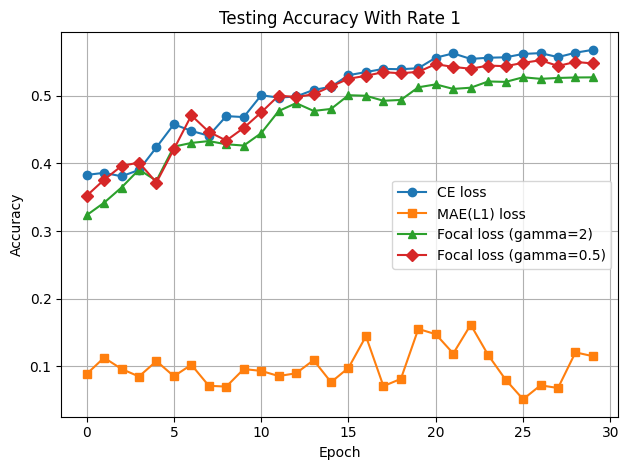

In [32]:
plt.plot(testing_acc1, label='CE loss',marker='o')
plt.plot(testing_acc2, label='MAE(L1) loss',marker='s')
plt.plot(testing_acc3, label='Focal loss (gamma=2)',marker='^')
plt.plot(testing_acc4, label='Focal loss (gamma=0.5)',marker='D')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Testing Accuracy With Rate 1')
plt.grid(True) 
plt.tight_layout()
plt.show()



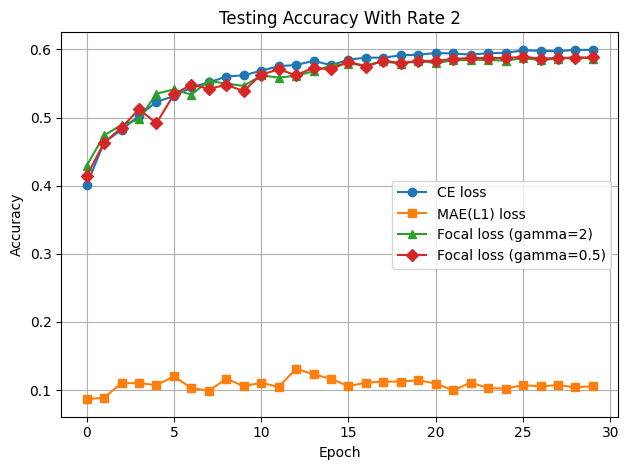

In [33]:
plt.plot(testing_acc1_2, label='CE loss',marker='o')
plt.plot(testing_acc2_2, label='MAE(L1) loss',marker='s')
plt.plot(testing_acc3_2, label='Focal loss (gamma=2)',marker='^')
plt.plot(testing_acc4_2, label='Focal loss (gamma=0.5)',marker='D')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Testing Accuracy With Rate 2')
plt.grid(True) 
plt.tight_layout()
plt.show()

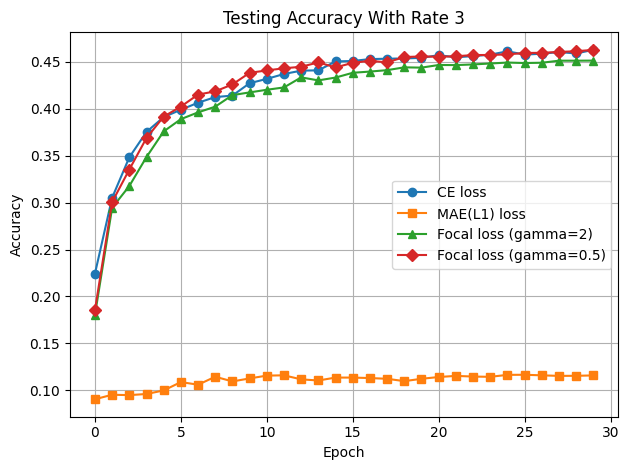

In [34]:
plt.plot(testing_acc1_3, label='CE loss',marker='o')
plt.plot(testing_acc2_3, label='MAE(L1) loss',marker='s')
plt.plot(testing_acc3_3, label='Focal loss (gamma=2)',marker='^')
plt.plot(testing_acc4_3, label='Focal loss (gamma=0.5)',marker='D')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Testing Accuracy With Rate 3')
plt.grid(True) 
plt.tight_layout()
plt.show()

### subplot with learning rate1e-1

**accuracy**

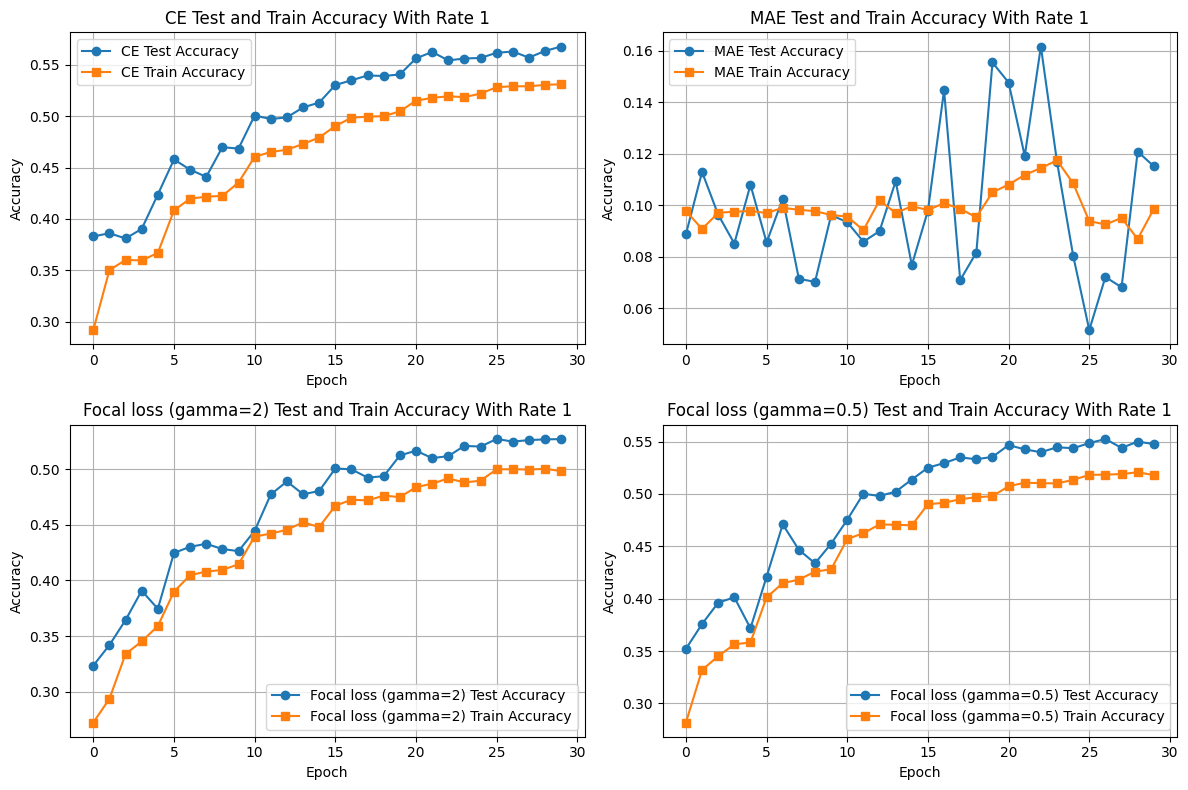

<Figure size 640x480 with 0 Axes>

In [35]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_acc1, label='CE Test Accuracy', marker='o')
axes[0, 0].plot(training_acc1, label='CE Train Accuracy', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Accuracy With Rate 1')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_acc2, label='MAE Test Accuracy', marker='o')
axes[0, 1].plot(training_acc2, label='MAE Train Accuracy', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Accuracy With Rate 1')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_acc3, label='Focal loss (gamma=2) Test Accuracy', marker='o')
axes[1, 0].plot(training_acc3, label='Focal loss (gamma=2) Train Accuracy', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Accuracy With Rate 1')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_acc4, label='Focal loss (gamma=0.5) Test Accuracy', marker='o')
axes[1, 1].plot(training_acc4, label='Focal loss (gamma=0.5) Train Accuracy', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Accuracy With Rate 1')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()

**loss**

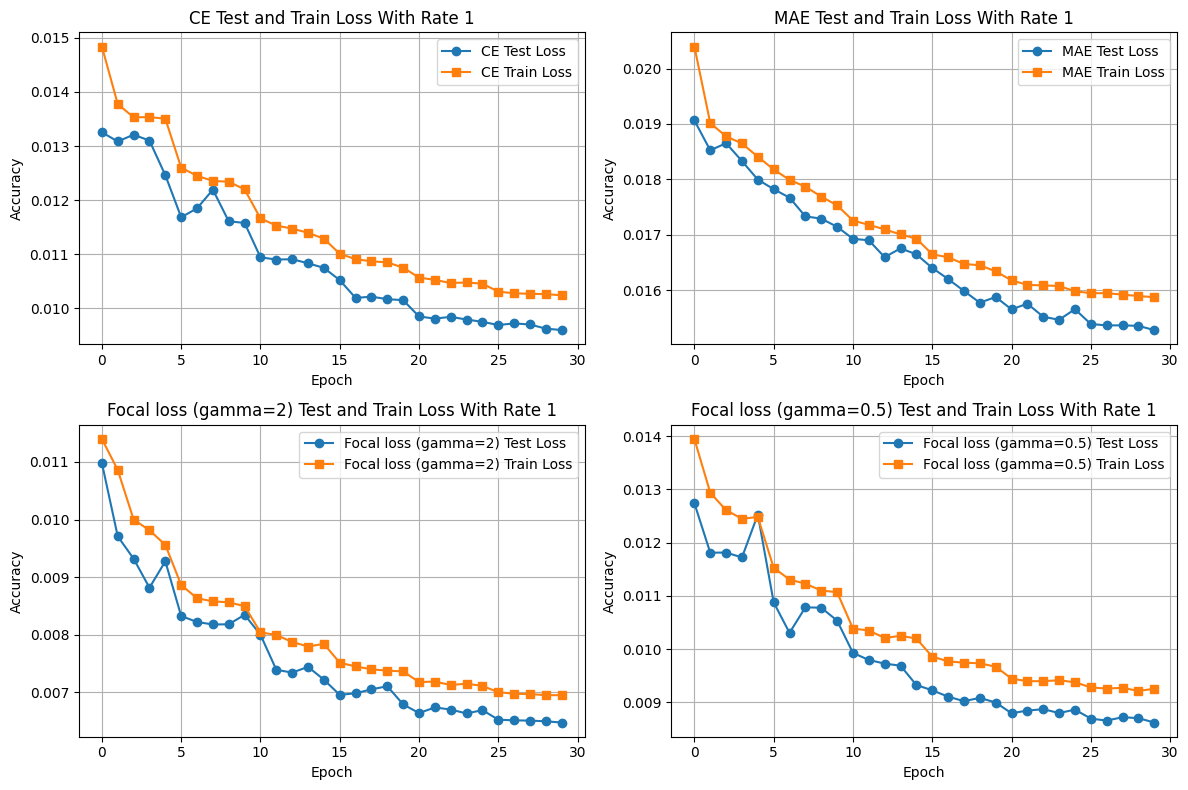

In [36]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_loss1, label='CE Test Loss', marker='o')
axes[0, 0].plot(training_loss1, label='CE Train Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Loss With Rate 1')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_loss2, label='MAE Test Loss', marker='o')
axes[0, 1].plot(training_loss2, label='MAE Train Loss', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Loss With Rate 1')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_loss3, label='Focal loss (gamma=2) Test Loss', marker='o')
axes[1, 0].plot(training_loss3, label='Focal loss (gamma=2) Train Loss', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Loss With Rate 1')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_loss4, label='Focal loss (gamma=0.5) Test Loss', marker='o')
axes[1, 1].plot(training_loss4, label='Focal loss (gamma=0.5) Train Loss', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Loss With Rate 1')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()




### learning rate 1e-2

**accuracy**

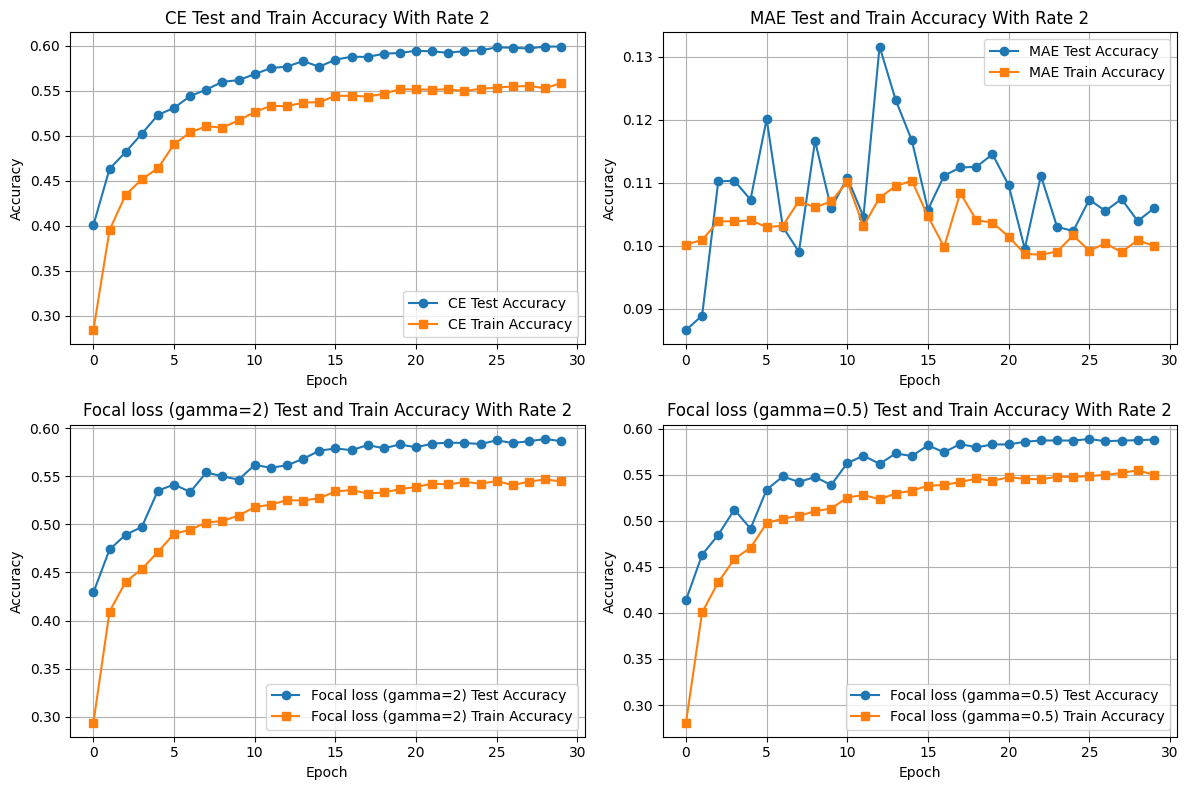

In [37]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_acc1_2, label='CE Test Accuracy', marker='o')
axes[0, 0].plot(training_acc1_2, label='CE Train Accuracy', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Accuracy With Rate 2')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_acc2_2, label='MAE Test Accuracy', marker='o')
axes[0, 1].plot(training_acc2_2, label='MAE Train Accuracy', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Accuracy With Rate 2')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_acc3_2, label='Focal loss (gamma=2) Test Accuracy', marker='o')
axes[1, 0].plot(training_acc3_2, label='Focal loss (gamma=2) Train Accuracy', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Accuracy With Rate 2')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_acc4_2, label='Focal loss (gamma=0.5) Test Accuracy', marker='o')
axes[1, 1].plot(training_acc4_2, label='Focal loss (gamma=0.5) Train Accuracy', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Accuracy With Rate 2')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()




**loss**

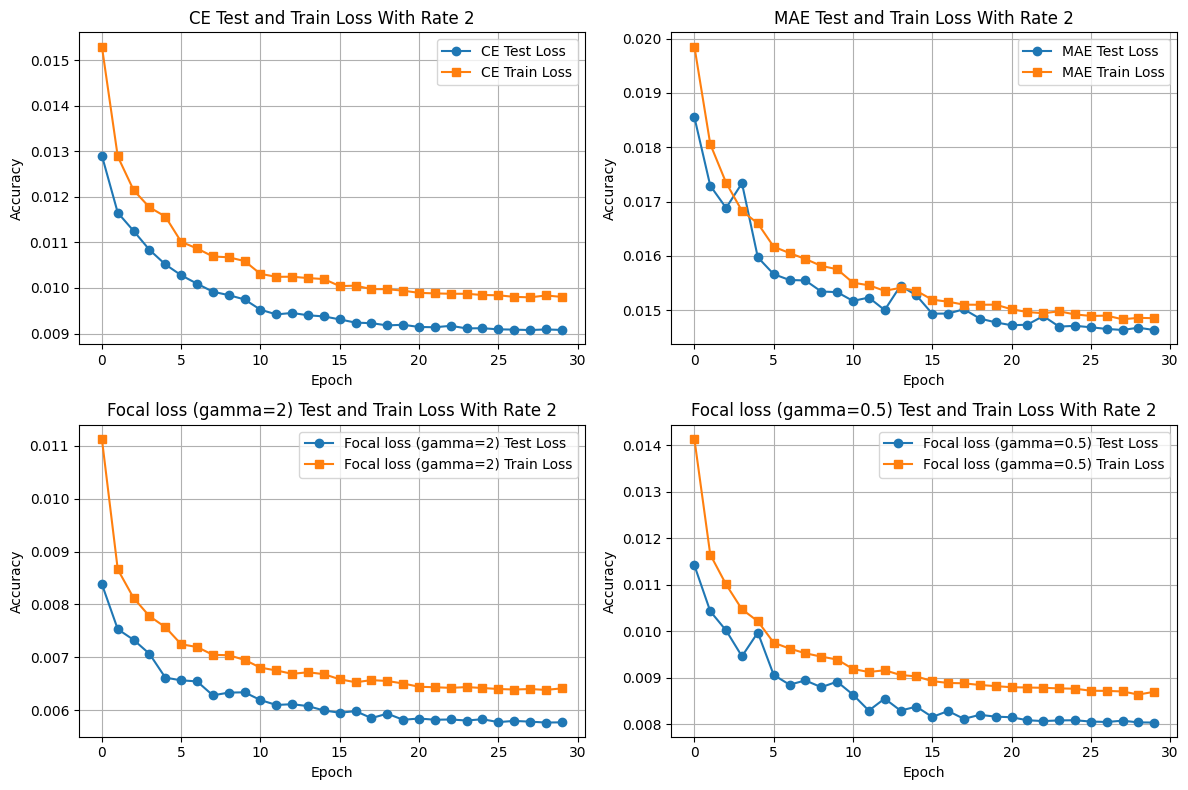

In [38]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_loss1_2, label='CE Test Loss', marker='o')
axes[0, 0].plot(training_loss1_2, label='CE Train Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Loss With Rate 2')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_loss2_2, label='MAE Test Loss', marker='o')
axes[0, 1].plot(training_loss2_2, label='MAE Train Loss', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Loss With Rate 2')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_loss3_2, label='Focal loss (gamma=2) Test Loss', marker='o')
axes[1, 0].plot(training_loss3_2, label='Focal loss (gamma=2) Train Loss', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Loss With Rate 2')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_loss4_2, label='Focal loss (gamma=0.5) Test Loss', marker='o')
axes[1, 1].plot(training_loss4_2, label='Focal loss (gamma=0.5) Train Loss', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Loss With Rate 2')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()





### learning rate 1e-3

**accuracy**

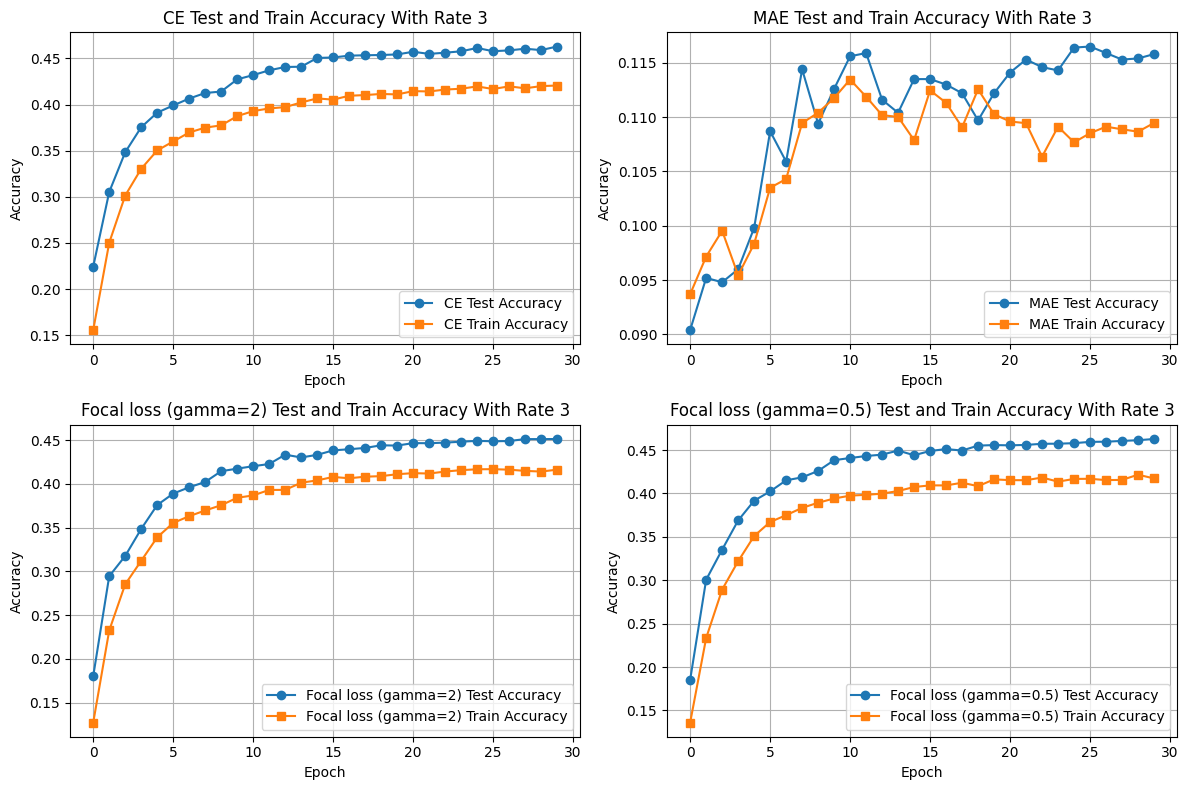

In [39]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_acc1_3, label='CE Test Accuracy', marker='o')
axes[0, 0].plot(training_acc1_3, label='CE Train Accuracy', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Accuracy With Rate 3')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_acc2_3, label='MAE Test Accuracy', marker='o')
axes[0, 1].plot(training_acc2_3, label='MAE Train Accuracy', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Accuracy With Rate 3')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_acc3_3, label='Focal loss (gamma=2) Test Accuracy', marker='o')
axes[1, 0].plot(training_acc3_3, label='Focal loss (gamma=2) Train Accuracy', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Accuracy With Rate 3')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_acc4_3, label='Focal loss (gamma=0.5) Test Accuracy', marker='o')
axes[1, 1].plot(training_acc4_3, label='Focal loss (gamma=0.5) Train Accuracy', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Accuracy With Rate 3')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()





**loss**

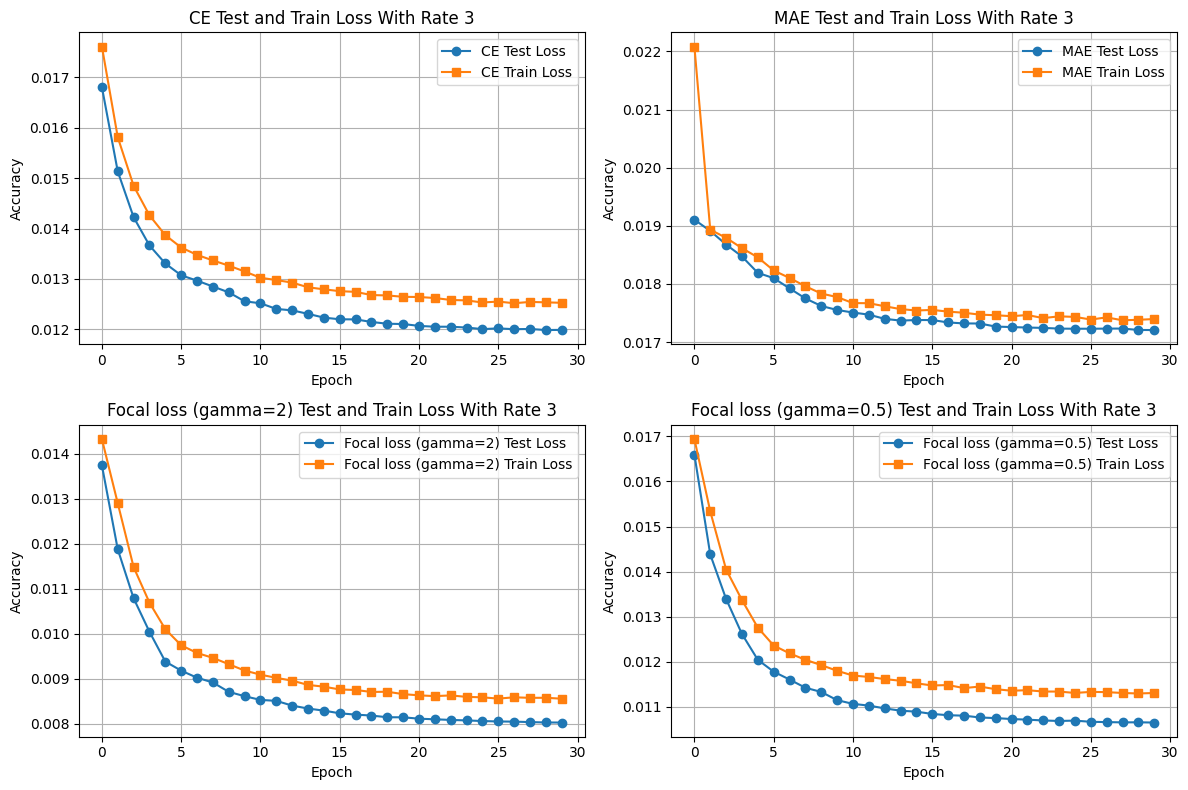

In [40]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first graph in the top-left subplot
axes[0, 0].plot(testing_loss1_3, label='CE Test Loss', marker='o')
axes[0, 0].plot(training_loss1_3, label='CE Train Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_title('CE Test and Train Loss With Rate 3')
axes[0, 0].grid(True)

# Plot the second graph in the top-right subplot
axes[0, 1].plot(testing_loss2_3, label='MAE Test Loss', marker='o')
axes[0, 1].plot(training_loss2_3, label='MAE Train Loss', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('MAE Test and Train Loss With Rate 3')
axes[0, 1].grid(True)

# Plot the third graph in the bottom-left subplot
axes[1, 0].plot(testing_loss3_3, label='Focal loss (gamma=2) Test Loss', marker='o')
axes[1, 0].plot(training_loss3_3, label='Focal loss (gamma=2) Train Loss', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Focal loss (gamma=2) Test and Train Loss With Rate 3')
axes[1, 0].grid(True)

# Plot the fourth graph in the bottom-right subplot
axes[1, 1].plot(testing_loss4_3, label='Focal loss (gamma=0.5) Test Loss', marker='o')
axes[1, 1].plot(training_loss4_3, label='Focal loss (gamma=0.5) Train Loss', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].set_title('Focal loss (gamma=0.5) Test and Train Loss With Rate 3')
axes[1, 1].grid(True)

# Add spacing between subplots
plt.tight_layout()

# Show the entire plot
plt.show()




